## Question 5: Extra Credit (15 points)

For extra credit, we will implement a smarter form of image blending, where seams are minimized. This can be used to handle exposure differences between stitches images, correct for motion blur, and even act as a photoshop healing tool. For examples in photo stitching, see [this link](http://www.cs.jhu.edu/~misha/Code/SMG/) or [this link](http://www.cs.jhu.edu/~misha/Code/DMG/Version4.5/).

### 5.1 (15 points)

In this section we will implement __Poisson Image Stitching__ \[perez2003poisson\] which can be used to create seamless photo montages. 

|<img align="center" src="figure/poisson_stitching.png" width="500">|
|:--:|
|Fig 5.1 Example of Possion image stitching.|

Write a function called $\texttt{poisson_blend(background,foreground,mask)}$ which takes 3 equal sized images (background and foreground as RGB, mask as binary) and solves the Poisson equation, using gradients from foreground and boundary conditions from the background. 

**The problem will be manually graded.** Please include results from the $\texttt{(fg1,bg1,mask1)}$ images in your write-up.

*Hint:* The basic idea behind Poisson Image Stitching is to setup a linear system $A x = b$ where each row of $A$ is the gradient operator for the image pixel mask (e.g. 4 for each pixel, and -1 +1 for it's 4 neighbors), while the row in $b$ contains known gradients from the foreground. Additional rows in $A$ are pixels on the boundary, which have known values, stored in $b$. Solving for $x$ then gives you pixel values for the entire masked patch. This is done for each image channel seperately. See [this page](http://www.ctralie.com/Teaching/PoissonImageEditing/) or [this page](http://cs.brown.edu/courses/csci1950-g/results/proj2/pdoran/index.html) if you need more information. 

In [2]:
import nbimporter
import cv2

import matplotlib.pyplot as plt
import numpy as np

from scipy.sparse.linalg import spsolve
from q2 import briefLite,briefMatch,plotMatches
from q3 import computeH_ransac

In [15]:
def is_border(mask, x, y, c):
    
    if (mask[x - 1, y, c] == 0) or (mask[x + 1, y, c] == 0) or \
        (mask[x, y - 1, c] == 0) or (mask[x, y + 1, c] == 0):
        return True
    
    return False

def poisson_blend(bg, fg, mask):
    
    blended_img = np.uint8(np.uint8(mask == 0) * bg + np.uint8(mask != 0) * fg)
    plt.imshow(blended_img)
    plt.show()
    
    mask_nzx, mask_nzy = np.nonzero(mask[:, :, 0])    
    mask_nz = [(int(x), int(y)) for x, y in zip(mask_nzx, mask_nzy)]
    N = len(mask_nz)
    
    A = np.eye(N, dtype=np.float32) * 4
    
    # Iterate through every non-zero pixel and fill A.
    for p in range(N):
        
        points = [(mask_nz[p][0] - 1, mask_nz[p][1]),
                  (mask_nz[p][0] + 1, mask_nz[p][1]), 
                  (mask_nz[p][0], mask_nz[p][1] - 1),
                  (mask_nz[p][0], mask_nz[p][1] + 1)]
        
        for x, y in points:            
            if (x, y) not in mask_nz:
                continue
            
            A[p, mask_nz.index((x, y))] = -1
    
    # Solve Ax=b for each channel.
    for c in range(blended_img.shape[-1]):
        b = np.zeros(N)
        
        for j in range(N): 
            b[j] = 4 * fg[mask_nz[j][0], mask_nz[j][1], c] \
                - fg[mask_nz[j][0] - 1, mask_nz[j][1], c] \
                - fg[mask_nz[j][0] + 1, mask_nz[j][1], c] \
                - fg[mask_nz[j][0], mask_nz[j][1] - 1, c] \
                - fg[mask_nz[j][0], mask_nz[j][1] + 1, c]
            
            if (is_border(mask, mask_nz[j][0], mask_nz[j][1], c)):
                if (mask[mask_nz[j][0] - 1, mask_nz[j][1], c] == 0):
                    b[j] += bg[mask_nz[j][0] - 1, mask_nz[j][1], c]
                else:
                    b[j] += fg[mask_nz[j][0] - 1, mask_nz[j][1], c]

                if (mask[mask_nz[j][0] + 1, mask_nz[j][1], c] == 0):
                    b[j] += bg[mask_nz[j][0] + 1, mask_nz[j][1], c]
                else:
                    b[j] += fg[mask_nz[j][0] + 1, mask_nz[j][1], c]

                if (mask[mask_nz[j][0], mask_nz[j][1] - 1, c] == 0):
                    b[j] += bg[mask_nz[j][0], mask_nz[j][1] - 1, c]
                else:
                    b[j] += fg[mask_nz[j][0], mask_nz[j][1] - 1, c]

                if (mask[mask_nz[j][0], mask_nz[j][1] + 1, c] == 0):
                    b[j] += bg[mask_nz[j][0], mask_nz[j][1] + 1, c]
                else:
                    b[j] += fg[mask_nz[j][0], mask_nz[j][1] + 1, c]
    
        i = np.linalg.solve(A, b)
        i = (i - np.min(i)) * 255. / (np.max(i) - np.min(i))
        blended_img[mask_nzx, mask_nzy, c] = i
    
    return np.uint8(blended_img)

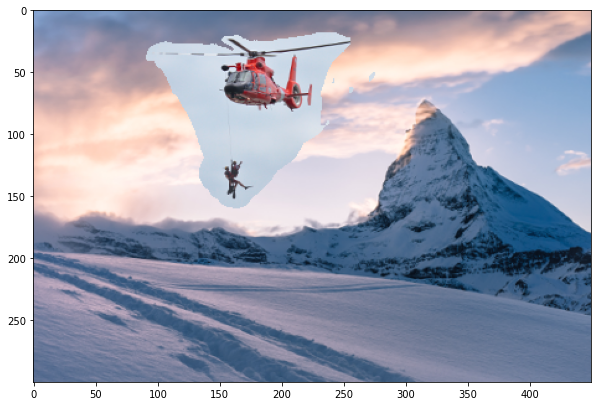

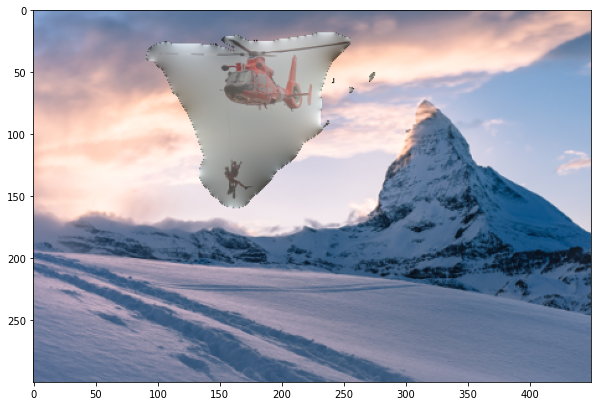

In [16]:
bg = cv2.imread('data/bg1.png')
fg = cv2.imread('data/fg1.png')
mask = cv2.imread('data/mask1.png')

bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
fg = cv2.cvtColor(fg, cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) / 255.

image = poisson_blend(bg, fg, mask)

plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(image)
plt.show()

In [ ]:
bg = cv2.imread('data/bg1.png')
fg = cv2.imread('data/fg1.png')
mask = cv2.imread('data/mask1.png')

bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
fg = cv2.cvtColor(fg, cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) / 255.

print(mask.shape)
print(bg.shape)
print(fg.shape)